# Ανάλυση Γονιδιακής Έκφρασης από GEO (Καρκίνος Πνεύμονα) Ανάλυση δεδομένων από GEO datasets (GSE31210, GSE19804) με στόχο την ταυτοποίηση σημαντικών γονιδίων στον καρκίνο του πνεύμονα.


# Φόρτωση GEO Datasets

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [4]:
# Φόρτωση datasets
df1 = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/matrix/GSE31210_series_matrix.txt.gz",
                  compression='gzip', sep='\t', comment='!', low_memory=False)

df2 = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE19nnn/GSE19804/matrix/GSE19804_series_matrix.txt.gz",
                  compression='gzip', sep='\t', comment='!', low_memory=False)

# Εύρεση Κοινών Γονιδίων και Προεπεξεργασία

In [5]:
# Βεβαιώνουμε ότι η πρώτη στήλη (ID_REF) είναι κοινή και στα τρία datasets
genes_1 = set(df1['ID_REF'])
genes_2 = set(df2['ID_REF'])

In [6]:
common_genes = genes_1.intersection(genes_2)

In [7]:
# Φιλτράρισμα των datasets μόνο για κοινά γονίδια
df1_filtered = df1[df1['ID_REF'].isin(common_genes)].set_index('ID_REF')
df2_filtered = df2[df2['ID_REF'].isin(common_genes)].set_index('ID_REF')

In [8]:
# Ταξινόμηση index ώστε να είναι ακριβώς ίδια σειρά
df1_filtered = df1[df1['ID_REF'].isin(common_genes)].set_index('ID_REF').sort_index()
df2_filtered = df2_filtered.sort_index()

In [9]:
# Τελικός έλεγχος για την ταύτιση index
assert all(df1_filtered.index == df2_filtered.index)

In [10]:
# Συνένωση των δεδομένων
df_combined = pd.concat([df1_filtered, df2_filtered,], axis=1)

# Έλεγχος Τύπου Αναγνωριστικών (ID_REF)

In [11]:
print("GSE43458 IDs:", df1['ID_REF'].head())
print("GSE31210 IDs:", df2['ID_REF'].head())



GSE43458 IDs: 0    1007_s_at
1      1053_at
2       117_at
3       121_at
4    1255_g_at
Name: ID_REF, dtype: object
GSE31210 IDs: 0    1007_s_at
1      1053_at
2       117_at
3       121_at
4    1255_g_at
Name: ID_REF, dtype: object


# Μετατροπή Αναγνωριστικών σε Gene Symbols

In [12]:
# Φόρτωσε το αρχείο που κατέβασες
annotation = pd.read_csv("datasets\GPL570-55999.txt", sep="\t", comment='#', low_memory=False)

# Δες ποιες στήλες έχει
print(annotation.columns)


<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\stama\AppData\Local\Temp\ipykernel_7672\1899038321.py:2: SyntaxWarning: invalid escape sequence '\G'
  annotation = pd.read_csv("datasets\GPL570-55999.txt", sep="\t", comment='#', low_memory=False)


Index(['ID', 'GB_ACC', 'SPOT_ID', 'Species Scientific Name', 'Annotation Date',
       'Sequence Type', 'Sequence Source', 'Target Description',
       'Representative Public ID', 'Gene Title', 'Gene Symbol',
       'ENTREZ_GENE_ID', 'RefSeq Transcript ID',
       'Gene Ontology Biological Process', 'Gene Ontology Cellular Component',
       'Gene Ontology Molecular Function'],
      dtype='object')


In [13]:
# Δημιουργούμε ένα λεξικό probe → gene
id_to_gene = dict(zip(annotation['ID'], annotation['Gene Symbol']))

# Εφαρμόζεις αυτό το mapping στα datasets GSE31210 και GSE19804
df2['Gene_Symbol'] = df2['ID_REF'].map(id_to_gene)
df1['Gene_Symbol'] = df1['ID_REF'].map(id_to_gene)


# Ομαδοποίηση Ανά Γονίδιο και Υπολογισμός Έκφρασης


In [14]:
# Βήμα 1: Κρατάμε μόνο τις αριθμητικές στήλες (δηλαδή τα δείγματα)
df2_numeric = df2.select_dtypes(include='number')
df1_numeric = df1.select_dtypes(include='number')

# Βήμα 2: Προσθέτουμε ξανά τα gene symbols ως στήλη
df2_numeric['Gene_Symbol'] = df2['Gene_Symbol']
df1_numeric['Gene_Symbol'] = df1['Gene_Symbol']

# Βήμα 3: Κάνουμε groupby και υπολογίζουμε τον μέσο όρο για κάθε γονίδιο
df2_grouped = df2_numeric.groupby('Gene_Symbol').mean()
df1_grouped = df1_numeric.groupby('Gene_Symbol').mean()


# Τελική Συνένωση Όλων των Δεδομένων


In [15]:
# Συνένωση κατά γονίδιο (γραμμές), οι στήλες (δείγματα) δεν επαναλαμβάνονται
combined_df = pd.concat([df2_grouped, df1_grouped], axis=1)

# Δες τι φτιάξαμε
print(combined_df.shape)
combined_df.head()


(23520, 366)


,GSM494556,GSM494557,GSM494558,GSM494559,GSM494560,GSM494561,GSM494562,GSM494563,GSM494564,GSM494565,...,GSM773776,GSM773777,GSM773778,GSM773779,GSM773780,GSM773781,GSM773782,GSM773783,GSM773784,GSM773785
Gene_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,6.376000,6.514450,6.935300,7.987240,7.931680,7.531040,6.922500,7.628280,7.24020,7.267070,...,50.813641,51.982870,46.984982,24.260811,50.404438,52.734867,52.912245,43.067164,40.169184,7.322948
A1BG-AS1,5.315020,5.032750,5.461360,5.812140,5.953150,5.800370,5.302210,5.581330,5.49403,5.342650,...,61.151523,76.560795,91.945839,68.984255,7.022719,51.320599,14.745603,64.812755,119.829274,8.107551
A1CF,7.397725,5.081705,4.759180,4.592725,4.652410,4.582735,4.886370,4.365795,4.51583,4.965115,...,25.849430,33.761611,47.827019,42.357287,26.442560,46.527127,33.422373,51.864429,31.129011,41.863779
A2M,9.548500,9.202655,9.744765,9.553915,9.420875,9.600145,8.897035,8.928620,9.50293,9.243995,...,8782.817786,9298.270346,9957.928594,9745.025715,9916.936047,9662.780993,10082.322964,13647.352951,7967.622052,10045.380457
A2M-AS1,6.206260,6.284620,8.054770,5.698790,6.214340,6.526420,4.727290,6.217280,7.03301,5.977370,...,295.488500,392.521100,373.392300,363.744200,279.185600,327.063400,473.129400,420.205500,284.472400,460.258800


# φορτώση δεδομένων και οργάνωση για ανάλυση

In [16]:
# Διαβάζει τα sample IDs
def load_clean_ids(path):
    with open(path, 'r') as f:
        return [line.strip().replace('"', '') for line in f if line.strip()]

cancer_samples = load_clean_ids(r"cancer-normal/cancer.txt")
normal_samples = load_clean_ids(r"cancer-normal/normal.txt")

# Φιλτράρει όσα υπάρχουν στο combined_df
cancer_samples = [s for s in cancer_samples if s in combined_df.columns]
normal_samples = [s for s in normal_samples if s in combined_df.columns]

print(f"Καρκινικά δείγματα: {len(cancer_samples)}")
print(f"Φυσιολογικά δείγματα: {len(normal_samples)}")


labels = pd.Series(
    ['cancer'] * len(cancer_samples) + ['normal'] * len(normal_samples),
    index=cancer_samples + normal_samples,
    name='label'
)

# Τελικό dataset (δείγματα x γονίδια + label)
expression_data = combined_df[cancer_samples + normal_samples].T
expression_data['label'] = labels

# ✅ Επιβεβαίωση
print("Τελικό σχήμα:", expression_data.shape)
expression_data.head()


Καρκινικά δείγματα: 286
Φυσιολογικά δείγματα: 80
Τελικό σχήμα: (366, 23521)


Gene_Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZYG11B,ZYX,ZZEF1,ZZZ3,abParts /// IGKC /// IGKV4-1 /// IGKV4-1,av27s1 /// TRAV39 /// TRAV39,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// MIRLET7BHG /// RP4-695O20__B.10,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// RP4-695O20__B.10,mir-223,label
GSM773540,47.90095,46.825111,72.714534,2228.911570,175.34674,22.831965,15.927107,12.925406,73.018596,101.416950,...,1030.160047,167.89290,345.420567,778.35785,6.886894,22.436699,13.242170,111.81361,13.521504,cancer
GSM773541,51.64328,8.059568,23.870435,4198.206655,142.80260,23.447401,31.932787,12.202017,46.112976,68.965219,...,2070.380533,487.50920,137.000604,1601.05855,528.101930,4.380360,4.805737,46.92550,105.879995,cancer
GSM773542,40.98813,10.234848,13.798074,4695.593220,142.81548,11.082931,31.783636,40.485352,51.898190,50.386010,...,1690.349143,384.43770,227.002517,1343.98745,210.150816,6.839572,3.302328,62.00354,205.846188,cancer
GSM773543,28.38625,8.138013,40.220118,6329.205170,106.75270,16.412923,39.129192,32.542745,19.044909,31.693239,...,2315.690700,330.22475,200.465752,1483.14315,262.979570,27.579258,9.878414,83.47410,21.877117,cancer
GSM773544,42.09003,10.482582,26.090287,3881.230130,240.99803,17.330212,23.747617,16.267970,32.913082,51.031890,...,1500.671390,274.26120,296.169413,1095.84360,609.263698,10.045916,2.294671,75.77886,17.893558,cancer


# PCA

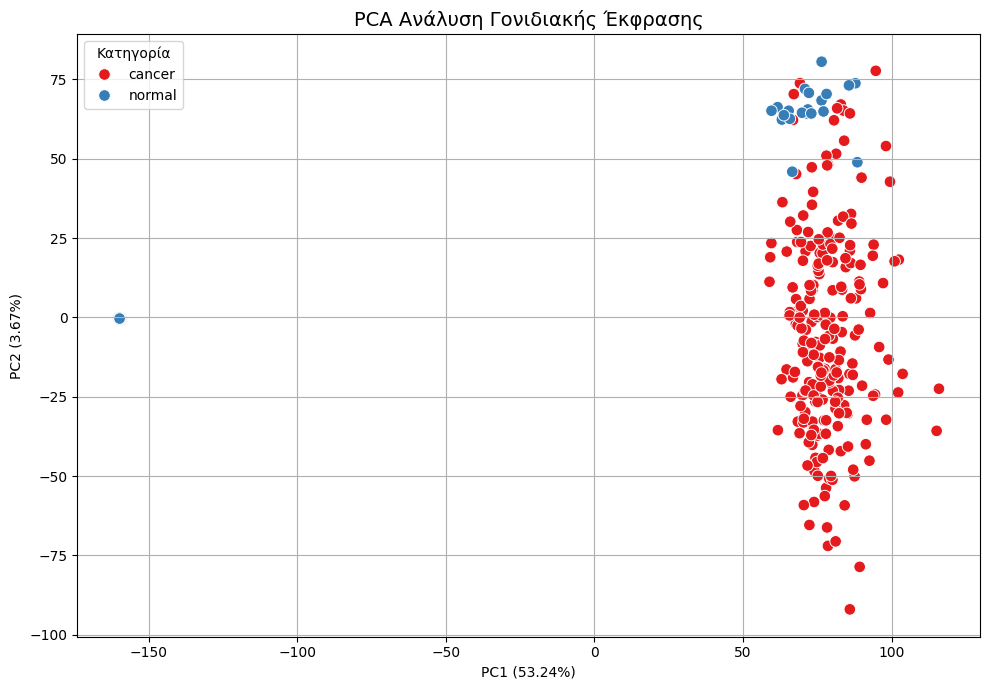

In [17]:
# 🔹 Χωρίζουμε features & labels
X = expression_data.drop(columns=['label'])
y = expression_data['label']

# 🔹 Κανονικοποίηση
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 PCA με 2 συνιστώσες
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🔹 Δημιουργία DataFrame για plot
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y.values

# 🔹 Οπτικοποίηση
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", s=70)
plt.title("PCA Ανάλυση Γονιδιακής Έκφρασης", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Κατηγορία")
plt.grid(True)
plt.tight_layout()
plt.show()


# Προετοιμασία και εκτέλεση t-test

In [18]:
# Ξεχωρίζουμε δεδομένα ανά ομάδα
cancer_data = expression_data[expression_data['label'] == 'cancer'].drop('label', axis=1)
normal_data = expression_data[expression_data['label'] == 'normal'].drop('label', axis=1)

# Αρχικοποίηση λίστας για αποτελέσματα
results = []

# T-test για κάθε γονίδιο
for gene in expression_data.columns[:-1]:  # αφαιρούμε τη στήλη "label"
    # t-test μεταξύ ομάδων
    t_stat, p_value = stats.ttest_ind(cancer_data[gene], normal_data[gene], equal_var=False)

    # Υπολογισμός fold change (mean cancer / mean normal)
    mean_cancer = np.mean(cancer_data[gene])
    mean_normal = np.mean(normal_data[gene])
    fold_change = mean_cancer / mean_normal if mean_normal != 0 else np.nan

    # Αποθήκευση αποτελεσμάτων
    results.append({
        'Gene': gene,
        'p-value': p_value,
        'Fold Change': fold_change,
        'log2(Fold Change)': np.log2(fold_change) if fold_change > 0 else np.nan
    })

# Μετατροπή σε DataFrame και ταξινόμηση κατά p-value
deg_results = pd.DataFrame(results)
deg_results = deg_results.sort_values(by='p-value')

# Αποθήκευση αποτελεσμάτων (προαιρετικό)
deg_results.to_csv('DEG_results.csv', index=False)

deg_results.head(10)

,Gene,p-value,Fold Change,log2(Fold Change)
14874,OCIAD2,2.173729e-60,14.383767,3.846370
65,ABCC3,1.176171e-56,18.971748,4.245781
1259,ARHGEF16,3.016604e-54,7.857011,2.973981
21058,TMED3,6.857149e-54,7.579829,2.922165
3358,CD24,1.008358e-53,11.058760,3.467118
5758,EFNA4,1.869009e-53,6.942767,2.795511
22354,VMP1,3.150950e-53,8.804873,3.138302
7263,GALNT7,3.280343e-53,9.379638,3.229532
16783,PYCR1,5.555090e-53,8.194952,3.034735
5336,DNAH14,5.727165e-53,6.865796,2.779427


# Volcano plot

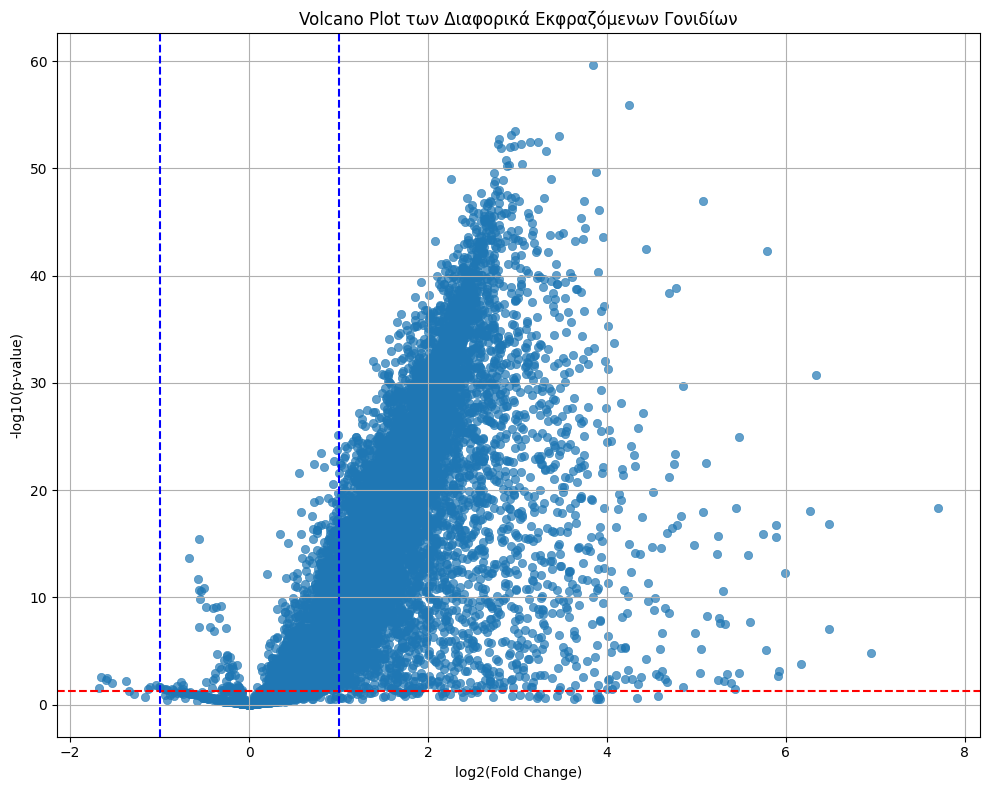

In [19]:
# Υπολογισμός -log10(p-value)
deg_results['-log10(p-value)'] = -np.log10(deg_results['p-value'])

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=deg_results, 
    x='log2(Fold Change)', 
    y='-log10(p-value)',
    edgecolor=None, alpha=0.7
)

# Όρια σημαντικότητας (παράδειγμα)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
plt.axvline(x=1, color='blue', linestyle='--')
plt.axvline(x=-1, color='blue', linestyle='--')

plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot των Διαφορικά Εκφραζόμενων Γονιδίων')

plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap top 50 γονίδια

C:\Users\stama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\stama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


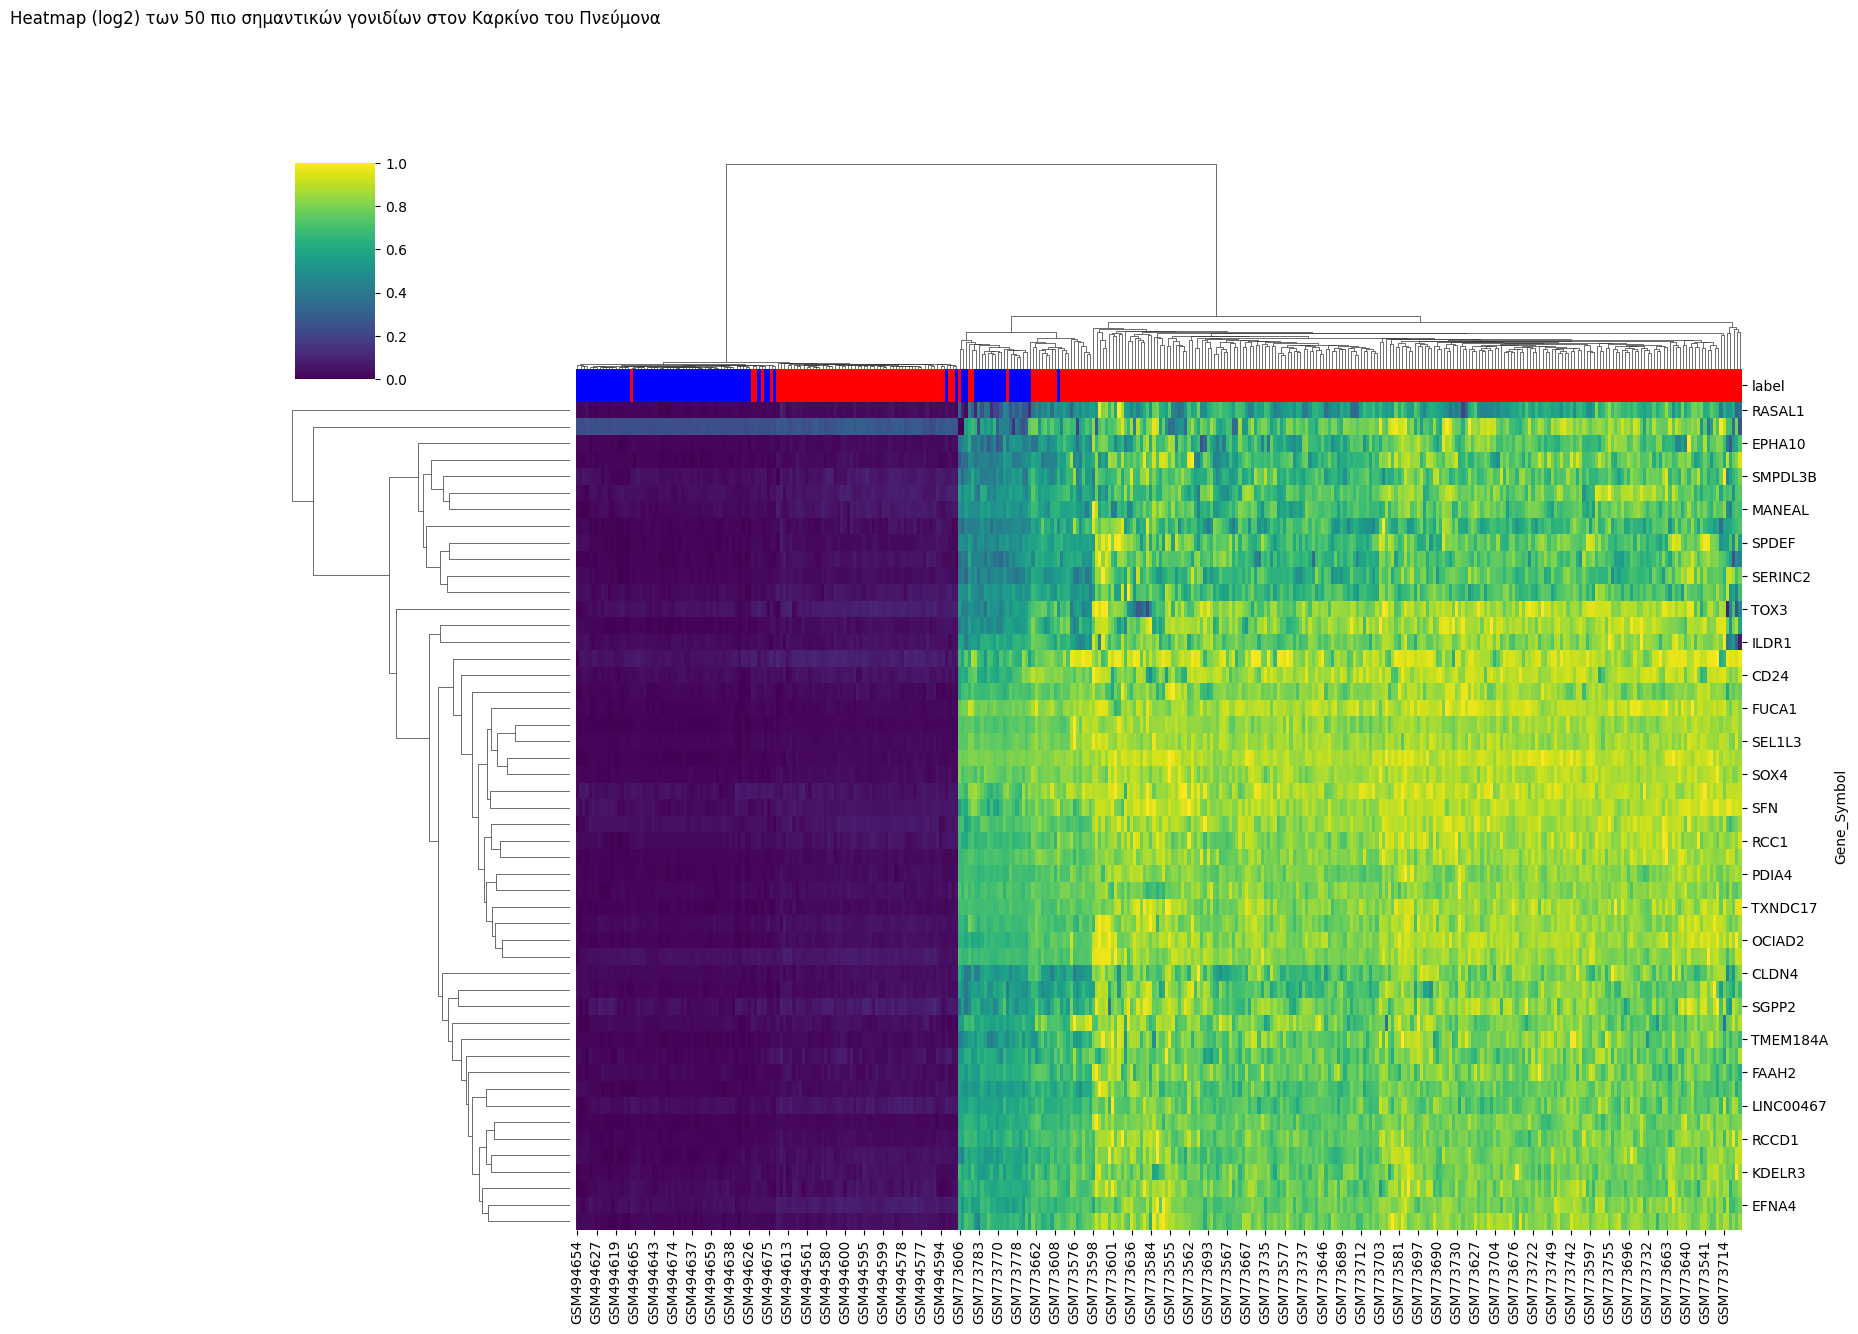

In [21]:
# Top 50 γονίδια με βάση το p-value
top_genes = deg_results.head(50)['Gene'].values

# Δημιουργία υποσυνόλου δεδομένων
heatmap_data = expression_data[top_genes.tolist() + ['label']]
heatmap_data_sorted = heatmap_data.sort_values('label')  

# Διαχωρίζουμε labels και δεδομένα
labels = heatmap_data_sorted.pop('label')

# Λογαριθμικός μετασχηματισμός δεδομένων
heatmap_data_log = np.log2(heatmap_data_sorted + 1)

# Δημιουργία χρωμάτων labels
label_colors = labels.map({'cancer': 'red', 'normal': 'blue'})

# Καθαρότερο heatmap
sns.clustermap(
    heatmap_data_log.transpose(),
    cmap='viridis',
    col_colors=label_colors,
    figsize=(16, 12),
    standard_scale=0  # κανονικοποίηση ανά γονίδιο
)

plt.title('Heatmap (log2) των 50 πιο σημαντικών γονιδίων στον Καρκίνο του Πνεύμονα', pad=100)
plt.show()

# MACHINE LEARNING BITCHES!!!!

# Προετοιμασία δεδομένων

In [22]:
# Επιλογή top 50 γονιδίων
top_genes = deg_results.head(50)['Gene'].tolist()

# Προετοιμασία δεδομένων ML
X = expression_data[top_genes]
y = expression_data['label'].map({'cancer':1, 'normal':0})  # μετατροπή σε 0/1


# train/test set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Εκπαίδευση Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Αξιολόγηση μοντέλου

Accuracy: 0.97
AUC Score: 1.00
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.96      0.98        72

    accuracy                           0.97        92
   macro avg       0.93      0.98      0.95        92
weighted avg       0.97      0.97      0.97        92



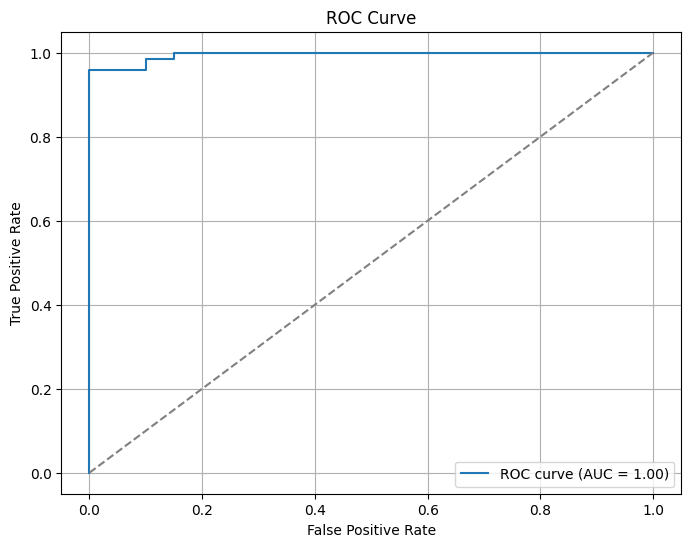

In [28]:
# Προβλέψεις
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Αξιολόγηση
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Feature Importance

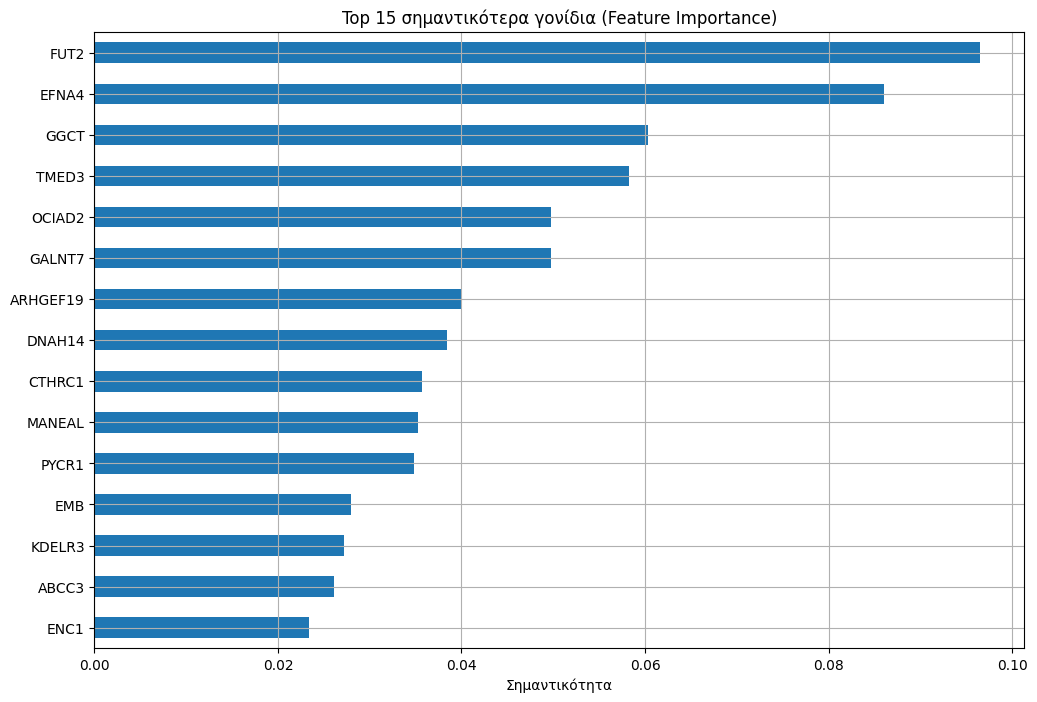

In [29]:
# Feature importances
importances = pd.Series(rf.feature_importances_, index=top_genes).sort_values(ascending=False)

# Οπτικοποίηση
plt.figure(figsize=(12,8))
importances.head(15).plot(kind='barh')
plt.title('Top 15 σημαντικότερα γονίδια (Feature Importance)')
plt.gca().invert_yaxis()
plt.xlabel('Σημαντικότητα')
plt.grid()
plt.show()
